# C01. Gambling
This evaluates gambling projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Sportsbook Review
- Dates:
    - Created: 3/30/2024
    - Updated: 5/5/2024

### Imports

In [90]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

In [91]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dates

In [92]:
start_date = todaysdate
end_date = todaysdate

### Games

In [93]:
game_df = read_and_save_games(team_map, generate=True)
game_df = game_df[(game_df['date'] >= start_date) & (game_df['date'] <= end_date)].reset_index(drop=True)

# Functions

##### Matchup

In [94]:
# This appends together all simulations for a specific game
def matchup_sim_scores(matchup_folder, matchup):
    # Initialize an empty list to store data frames
    dfs = []

    # Loop through each file in the directory
    for filename in os.listdir(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", matchup_folder, matchup)):
        if filename.endswith(".csv"):
            # Read the CSV file
            df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", matchup_folder, matchup, filename))

            # Add a column with the file name
            df['sim'] = int(filename.split("_")[1].replace(".csv", ""))

            # Append the DataFrame to the list
            dfs.append(df)

    # Concatenate all DataFrames in the list
    result = pd.concat(dfs, ignore_index=True)

    # Sort by sim number
    result.sort_values('sim', inplace=True)
    
    # Matchup
    result['matchup'] = matchup
    # Extract date
    result['date'] = int(matchup_folder[-8:])
    # Extract time
    result['time'] = int(matchup[-4:])
    # Extract game_id
    result['game_id'] = int(matchup.split(" ")[1])
    # Extract teams
    result['away'] = matchup.split("@")[0]
    
    return result

##### Day

In [95]:
# This appends together all simulations for a specific day
def daily_sim_scores(matchup_folder):
    # Add all daily game sim dataframes together
    daily_files = []
    for matchup in os.listdir(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", matchup_folder)):
        game_sim_scores = matchup_sim_scores(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", matchup_folder), matchup)
        daily_files.append(game_sim_scores)

    # Concatenate all game files together
    daily_sim_df = pd.concat(daily_files, axis=0)

    # Find the minimum and maximum times per date and matchup
    daily_sim_df['min_time'] = daily_sim_df.groupby(['matchup', 'date'])['time'].transform('min')
    daily_sim_df['max_time'] = daily_sim_df.groupby(['matchup', 'date'])['time'].transform('max')

    # Assign game numbers based on minimum and maximum times
    daily_sim_df['game_num'] = 1
    daily_sim_df.loc[(daily_sim_df['time'] == daily_sim_df['max_time']) & (daily_sim_df['min_time'] != daily_sim_df['max_time']), 'game_num'] = 2

    # Drop the intermediate columns if needed
    daily_sim_df = daily_sim_df.drop(['min_time', 'max_time'], axis=1)

    # Merge to acquire BASEBALLPRESSTEAM
    daily_sim_df = daily_sim_df.merge(team_map[['BBREFTEAM', 'BASEBALLPRESSTEAM']], left_on='away', right_on='BBREFTEAM', how='left')

    # Rename for later merging
    daily_sim_df.rename(columns={'BASEBALLPRESSTEAM':'VisitorTeamShort'}, inplace=True)

    # Keep relevant songs
    daily_sim_df = daily_sim_df[['game_id', 'date', 'game_num', 'VisitorTeamShort', 'away_score', 'home_score']]

    return daily_sim_df

### Odds

##### Read in Odds files

Fantasy Labs

In [96]:
def read_odds(date):  
    # Read in odds
    df = pd.read_csv(os.path.join(baseball_path, "A08. Odds", f"Odds {date}.csv"))
   
    
    # Identify which game comes first
    df.sort_values(by=['VisitorTeamShort', 'EventDateTime'], inplace=True)
    df['game_num'] = df.groupby(['VisitorTeamShort']).cumcount()+1
    
    df['date'] = df['date'].astype('str')                  
    
    return df

Odds API (Deprecated)

In [97]:
def read_odds2(date):
    # Read in odds
    df = pd.read_csv(os.path.join(baseball_path, "A08. Odds API", "Clean", f"Odds {date}.csv"))
    
    # Identify which game comes first
    df.sort_values(by=['VisitorTeamShort', 'EventDateTime'], inplace=True)
    df['game_num'] = df.groupby(['VisitorTeamShort']).cumcount()+1
    
    df['date'] = df['date'].astype('str')
    
    return df

Sportsbook Review

In [98]:
def read_odds3(date):  
    # Read in odds
    df = pd.read_csv(os.path.join(baseball_path, "A08. Odds Sportsbook Review", f"Odds {date}.csv"))
   
    
    # Identify which game comes first
    df.sort_values(by=['VisitorTeamShort', 'EventDateTime'], inplace=True)
    df['game_num'] = df.groupby(['VisitorTeamShort']).cumcount()+1
    
    df['date'] = df['date'].astype('str')                  
    
    return df

##### Calculate gambling stats for sims

In [99]:
def gambling_stats_sim(df):
    ### OU
    # Sim total
    df['total_proj'] = df[['away_score', 'home_score']].sum(axis=1)
    # Sim suggests the over
    df['over_proj'] = (df['total_proj'] > df['OU']).astype('int')
    # Sim suggests the under
    df['under_proj'] = (df['total_proj'] < df['OU']).astype('int')
    # Sim suggests push
    df['push_proj'] = (df['total_proj'] == df['OU']).astype('int')

    # Actual total
    df['total_act'] = df[['away_score_act', 'home_score_act']].sum(axis=1)
    # Over hits
    df['over_act'] = (df['total_act'] > df['OU']).astype('int')
    # Under hits
    df['under_act'] = (df['total_act'] < df['OU']).astype('int')
    # Push
    df['push_act'] = (df['total_act'] == df['OU']).astype('int')
    
    ### Spread
    # Sim projects away covers
    df['away_sp_proj'] = (df['away_score'] > (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects home covers
    df['home_sp_proj'] = (df['away_score'] < (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects push
    df['push_sp_proj'] = (df['away_score'] == (df['home_score'] + df['Spread'])).astype('int')

    # Away team covers
    df['away_sp_act'] = (df['away_score_act'] > (df['home_score_act'] + df['Spread'])).astype('int')
    # Home team covers
    df['home_sp_act'] = (df['away_score_act'] < (df['home_score_act'] + df['Spread'])).astype('int')
    # Push
    df['push_sp_act'] = (df['away_score_act'] == (df['home_score_act'] + df['Spread'])).astype('int')
    
    
    ### ML
    # Sim projects away team wins
    df['away_ml_proj'] = (df['away_score'] > df['home_score']).astype('int')
    # Sim projects home team wins
    df['home_ml_proj'] = (df['away_score'] < df['home_score']).astype('int')

    # Away team wins
    df['away_ml_act'] = (df['away_score_act'] > df['home_score_act']).astype('int')
    # Home team wins
    df['home_ml_act'] = (df['away_score_act'] < df['home_score_act']).astype('int')
    
    # Convert to numeric
    df['away_score_act'] = df['away_score_act'].astype('int')
    df['home_score_act'] = df['home_score_act'].astype('int')
     
    # df_grouped = df.groupby('game_id')[numeric_columns].mean().reset_index()
    df_grouped = df.groupby(['game_id', 'away_team', 'home_team']).mean(numeric_only=True).reset_index()
    

    return df_grouped

##### Convert American odds to payout multipliers

In [100]:
def multipliers(odds):
    if odds == 0:
        return np.nan
    
    elif odds > 0:
        mult = odds / 100 + 1
    else: 
        mult = 100 / odds * - 1 + 1
        
    return mult

##### Calculate gambling stats for matchups

In [101]:
def gambling_stats_games(df):
    # Calculate gambling stats for sims
    df_grouped = gambling_stats_sim(df)
    

    # Convert American odds to multipliers
    for col in ['SpreadMoney1', 'SpreadMoney2', 'OuMoney1', 'OuMoney2', 'MLMoney1', 'MLMoney2']:
        df_grouped[col] = df_grouped[col].apply(multipliers)

    ### Calculate predicted payouts
    # Spreads
    df_grouped['AwaySpreadPred'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_proj'] + df_grouped['push_sp_proj']
    df_grouped['HomeSpreadPred'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_proj'] + df_grouped['push_sp_proj']

    # Over/Unders
    df_grouped['OverPred'] = df_grouped['OuMoney1'] * df_grouped['over_proj'] + df_grouped['push_proj']
    df_grouped['UnderPred'] = df_grouped['OuMoney2'] * df_grouped['under_proj'] + df_grouped['push_proj']

    # ML
    df_grouped['AwayMLPred'] = df_grouped['MLMoney1'] * df_grouped['away_ml_proj']
    df_grouped['HomeMLPred'] = df_grouped['MLMoney2'] * df_grouped['home_ml_proj']

    ### Calculate actual payouts
    # Spreads
    df_grouped['AwaySpreadAct'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_act']
    df_grouped['HomeSpreadAct'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_act']
    # Adjust for pushes
    df_grouped['AwaySpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['AwaySpreadAct'])
    df_grouped['HomeSpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['HomeSpreadAct'])
    

    # Over/Unders
    df_grouped['OverAct'] = df_grouped['OuMoney1'] * df_grouped['over_act']
    df_grouped['UnderAct'] = df_grouped['OuMoney2'] * df_grouped['under_act']
    # Adjust for pushes
    df_grouped['OverAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['OverAct'])
    df_grouped['UnderAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['UnderAct'])

    # ML
    df_grouped['AwayMLAct'] = df_grouped['MLMoney1'] * df_grouped['away_ml_act']
    df_grouped['HomeMLAct'] = df_grouped['MLMoney2'] * df_grouped['home_ml_act']


    ### Pick bets
    # Spread
    df_grouped['SpreadPick'] = np.where(df_grouped['AwaySpreadPred'] >= 1, "Away", "Home")
    df_grouped['SpreadPick'] = np.where((df_grouped['AwaySpreadPred'] < 1) & (df_grouped['HomeSpreadPred'] < 1), "Neither", df_grouped['SpreadPick'])

    # Over/Under
    df_grouped['OverUnderPick'] = np.where(df_grouped['UnderPred'] >= 1, "Under", "Over")
    df_grouped['OverUnderPick'] = np.where((df_grouped['UnderPred'] < 1) & (df_grouped['OverPred'] < 1), "Neither", df_grouped['OverUnderPick'])

    # ML
    df_grouped['MLPick'] = np.where(df_grouped['AwayMLPred'] >= 1, "Away", "Home")
    df_grouped['MLPick'] = np.where((df_grouped['AwayMLPred'] < 1) & (df_grouped['HomeMLPred'] < 1), "Neither", df_grouped['MLPick'])


    ### Calculate winnings
    # Spread
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Away", df_grouped['AwaySpreadAct'], df_grouped['HomeSpreadAct'])
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Neither", np.nan, df_grouped['SpreadPayout'])

    # Over/Under
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Under", df_grouped['UnderAct'], df_grouped['OverAct'])
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Neither", np.nan, df_grouped['OverUnderPayout'])

    # ML
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Away", df_grouped['AwayMLAct'], df_grouped['HomeMLAct'])
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Neither", np.nan, df_grouped['MLPayout'])
    
    
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['AwaySpreadPred'] > 1, df_grouped['AwaySpreadPred'], df_grouped['HomeSpreadPred'])
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['SpreadPayoutPred'] < 1, np.nan, df_grouped['SpreadPayoutPred'])
    
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverPred'] > 1, df_grouped['OverPred'], df_grouped['UnderPred'])
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverUnderPayoutPred'] < 1, np.nan, df_grouped['OverUnderPayoutPred'])
    
    df_grouped['MLPayoutPred'] = np.where(df_grouped['AwayMLPred'] > 1, df_grouped['AwayMLPred'], df_grouped['HomeMLPred'])
    df_grouped['MLPayoutPred'] = np.where(df_grouped['MLPayoutPred'] < 1, np.nan, df_grouped['MLPayoutPred'])
    
    
    return df_grouped

##### Calculate errors and squared errors

In [102]:
def vegas_runs(gambling_df):
    gambling_df.rename(columns={'away_score': 'VisitorModelRuns', 'home_score': 'HomeModelRuns'}, inplace=True)

    gambling_df['VisitorModelError'] = gambling_df['VisitorModelRuns'] - gambling_df['away_score_act']
    gambling_df['VisitorVegasError'] = gambling_df['VisitorVegasRuns'] - gambling_df['away_score_act']

    gambling_df['VisitorModelSqError'] = gambling_df['VisitorModelError'] ** 2
    gambling_df['VisitorVegasSqError'] = gambling_df['VisitorVegasError'] ** 2

    gambling_df['HomeModelError'] = gambling_df['HomeModelRuns'] - gambling_df['home_score_act']
    gambling_df['HomeVegasError'] = gambling_df['HomeVegasRuns'] - gambling_df['home_score_act']

    gambling_df['HomeModelSqError'] = gambling_df['HomeModelError'] ** 2
    gambling_df['HomeVegasSqError'] = gambling_df['HomeVegasError'] ** 2
    
    # Total runs
    gambling_df['total_act'] = gambling_df['away_score_act'] + gambling_df['home_score_act']
    gambling_df['TotalVegasRuns'] = gambling_df['VisitorVegasRuns'] + gambling_df['HomeVegasRuns']

    return gambling_df

##### Determine spread side

In [103]:
# Function to determine SpreadSide
def determine_spread_side(row):
    if (row['SpreadPick'] == 'Away' and row['Spread'] < 0) or (row['SpreadPick'] == 'Home' and row['Spread'] > 0):
        return 'Underdog'
    elif (row['SpreadPick'] == 'Away' and row['Spread'] > 0) or (row['SpreadPick'] == 'Home' and row['Spread'] < 0):
        return 'Favorite'
    else:
        return 'Neither'

##### Graphs

In [104]:
def payout_plotter(gambling_df, bet, range_width=0.1, ax=None):
    gambling_df[f'{bet}PayoutGroup'] = gambling_df[f'{bet}PayoutPred'] // range_width * range_width

    # Group by SpreadPayoutGroup and calculate the average SpreadMoney for each group
    grouped_data = gambling_df.groupby(f'{bet}PayoutGroup')[f'{bet}Payout'].mean().reset_index()

    # Use existing axis if provided, otherwise create a new subplot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Create a scatter plot
    ax.scatter(grouped_data[f'{bet}PayoutGroup'], grouped_data[f'{bet}Payout'], color='blue', alpha=0.7)

    # Set specific axis limits and ticks with intervals of 0.1
    ax.set_xlim(0.8, 2.0)
    ax.set_xticks(np.arange(0.7, 2.1, 0.1))
    ax.set_ylim(0.8, 2.0)
    ax.set_yticks(np.arange(0.7, 2.1, 0.1))

    ax.set_title(f'Average {bet}PayoutPred vs {bet}Payout')
    ax.set_xlabel(f'{bet}PayoutGroup')
    ax.set_ylabel(f'Average {bet}PayoutPred')
    ax.grid(True)

##### Significance Test

In [105]:
def significance_test(df, bet, threshold, alpha=0.05):
    test_list = list(df.query(f'{bet}PayoutPred >= {threshold}')[f'{bet}Payout'])
    test_list = [x for x in test_list if not math.isnan(x)]
    
    average_payout = round(np.mean(test_list), 5)
    sample_size = len(test_list)
    
    # Calculate the average of the list
    # Perform a one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(test_list, 1)

    if p_value < alpha:
        significant = "Yes"
    else:
        significant = "No"
    
    # Check if the p-value is less than the significance level
    return average_payout, sample_size, p_value, significant
    # print(f"Average: {average_payout}, n: {sample_size}, p_value: {round(p_value, 3)}, significant: {significant}")

# Run

### Sims

In [106]:
# List of matchup folders within specified date
matchup_folders = os.listdir(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims"))
matchup_folders = [date for date in matchup_folders if int(start_date) <= int(date[-8:]) <= int(end_date)]

In [107]:
%%time
# Create sim dataframe
game_sims_list = Parallel(n_jobs=-1)(delayed(daily_sim_scores)(matchup_folder) for matchup_folder in matchup_folders)
sim_df = pd.concat(game_sims_list, axis=0)

# Merge in team abbreviation
sim_df = sim_df.merge(team_map[['BASEBALLPRESSTEAM', 'BBREFTEAM']], left_on=['VisitorTeamShort'], right_on=['BASEBALLPRESSTEAM'], how='left')

CPU times: total: 15.6 ms
Wall time: 36.8 s


In [108]:
sim_df.head(2)

,game_id,date,game_num,VisitorTeamShort,away_score,home_score,BASEBALLPRESSTEAM,BBREFTEAM
0,746153,20240505,1,ATL,2,1,ATL,ATL
1,746153,20240505,1,ATL,7,3,ATL,ATL


### Odds

In [109]:
# Loop over unique dates features in simulation results
odds_files = []
for date in list(sim_df['date'].unique()):
    try:
        # read_odds is fantasylabs, read_odds2 is Odds API (deprecated), and read_odds3 is Sportsbook Review (preferred)
        daily_odds_df = read_odds3(date)
        odds_files.append(daily_odds_df)
    except:
        pass

# Create dataframe
odds_df = pd.concat(odds_files, axis=0).reset_index(drop=True)
odds_df['date'] = odds_df['date'].astype(int)

# Merge in team abbreviation
odds_df = odds_df.merge(team_map[['SFBBTEAM', 'BBREFTEAM']], left_on=['VisitorTeamShort'], right_on=['SFBBTEAM'], how='left')

In [110]:
odds_df.head(2)

,VisitorTeamShort,HomeTeamShort,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,EventDateTime,date,game_num,SFBBTEAM,BBREFTEAM
0,ATL,LAD,1.500000,8.500000,110,-130,-102,-118,-155,130,NaN,NaN,2024-05-05 20:10:00,20240505,1,ATL,ATL
1,BAL,CIN,-1.500000,9.000000,-185,154,100,-120,114,-135,NaN,NaN,2024-05-05 20:10:00,20240505,1,BAL,BAL


### Merge

In [111]:
# Merge sims with actual results
gambling_df = pd.merge(sim_df, game_df, on='game_id', how='left', suffixes=("", "_act"))
# Merge with gambling information
gambling_df = pd.merge(gambling_df, odds_df, on=['date', 'game_num', 'BBREFTEAM'], how='inner')

In [112]:
gambling_df.head(2)

,game_id,date,game_num,VisitorTeamShort_x,away_score,home_score,BASEBALLPRESSTEAM,BBREFTEAM,game_datetime,game_date,game_type,status,away_id,home_id,doubleheader,game_num_act,home_probable_pitcher,away_probable_pitcher,home_pitcher_note,away_pitcher_note,away_score_act,home_score_act,current_inning,inning_state,venue_id,venue_name,national_broadcasts,series_status,summary,winning_team,losing_team,winning_pitcher,losing_pitcher,save_pitcher,losing_Team,date_act,year,away_team,home_team,VisitorTeamShort_y,HomeTeamShort,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,EventDateTime,SFBBTEAM
0,746153,20240505,1,ATL,2,1,ATL,ATL,2024-05-05T20:10:00Z,2024-05-05,R,Pre-Game,144,119,N,1,James Paxton,Max Fried,,,0,0,1,Top,22,Dodger Stadium,[MLB.tv Free Game],LAD leads 2-0,2024-05-05 - Atlanta Braves @ Los Angeles Dodgers (Pre-Game),NaN,NaN,NaN,NaN,NaN,NaN,20240505,2024,ATL,LAD,ATL,LAD,1.500000,8.500000,110,-130,-102,-118,-155,130,NaN,NaN,2024-05-05 20:10:00,ATL
1,746153,20240505,1,ATL,7,3,ATL,ATL,2024-05-05T20:10:00Z,2024-05-05,R,Pre-Game,144,119,N,1,James Paxton,Max Fried,,,0,0,1,Top,22,Dodger Stadium,[MLB.tv Free Game],LAD leads 2-0,2024-05-05 - Atlanta Braves @ Los Angeles Dodgers (Pre-Game),NaN,NaN,NaN,NaN,NaN,NaN,20240505,2024,ATL,LAD,ATL,LAD,1.500000,8.500000,110,-130,-102,-118,-155,130,NaN,NaN,2024-05-05 20:10:00,ATL


### Calculate Stats

In [113]:
# Calculate gambling payouts
gambling_df = gambling_stats_games(gambling_df)
# Calculate errors and MSEs in runs
gambling_df = vegas_runs(gambling_df)
# Add spread
gambling_df['SpreadAct'] = gambling_df[['AwaySpreadAct', 'HomeSpreadAct']].sum(axis=1)
# Add spread side
gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)
# Add total runs
gambling_df['TotalModelRuns'] = gambling_df[['VisitorModelRuns', 'HomeModelRuns']].sum(axis=1)

### Clean

In [114]:
# Drop first instance of games that were postponed
gambling_df.drop_duplicates(subset=['game_id'], keep='last', inplace=True)
gambling_df.reset_index(inplace=True, drop=True)

### Evaluations

In [115]:
print(gambling_df['OverUnderPick'].value_counts())
print(gambling_df['SpreadSide'].value_counts())

OverUnderPick
Neither    6
Over       6
Under      2
Name: count, dtype: int64
SpreadSide
Underdog    8
Neither     3
Favorite    3
Name: count, dtype: int64


In [116]:
gambling_df[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act', 'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].describe()

,VisitorModelRuns,HomeModelRuns,VisitorVegasRuns,HomeVegasRuns,away_score_act,home_score_act,VisitorModelSqError,HomeModelSqError,VisitorVegasSqError,HomeVegasSqError
count,14.000000,14.000000,0.000000,0.000000,14.000000,14.000000,14.000000,14.000000,0.000000,0.000000
mean,4.210176,4.266086,NaN,NaN,0.571429,0.428571,14.696407,15.959867,NaN,NaN
std,0.349463,0.392670,NaN,NaN,1.089410,0.937614,7.160177,7.038151,NaN,NaN
min,3.659722,3.583333,NaN,NaN,0.000000,0.000000,0.875190,0.802517,NaN,NaN
25%,3.950645,3.969494,NaN,NaN,0.000000,0.000000,11.906434,13.393731,NaN,NaN
50%,4.226687,4.261905,NaN,NaN,0.000000,0.000000,16.516519,18.165825,NaN,NaN
75%,4.478671,4.497024,NaN,NaN,0.750000,0.000000,20.060411,20.228186,NaN,NaN
max,4.802579,4.936508,NaN,NaN,3.000000,3.000000,23.064769,24.369111,NaN,NaN


##### Graph Payouts

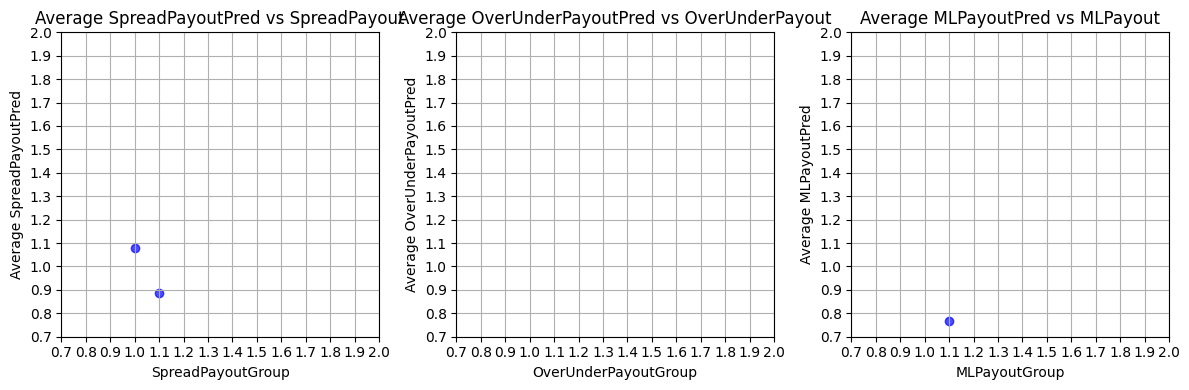

			Spread: 1.043					OverUnder: 0.473				Money Line: 0.702


In [117]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(gambling_df, 'Spread', ax=axes[0])
payout_plotter(gambling_df, 'OverUnder', ax=axes[1])
payout_plotter(gambling_df, 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = gambling_df['SpreadPayout'].mean()
OverUnderMean = gambling_df['OverUnderPayout'].mean()
MLMean = gambling_df['MLPayout'].mean()
print(f"\t\t\tSpread: {round(SpreadMean, 3)}\t\t\t\t\tOverUnder: {round(OverUnderMean, 3)}\t\t\t\tMoney Line: {round(MLMean, 3)}")

In [118]:
average_payout, sample_size, p_value, significant = significance_test(gambling_df, "Spread", 1.0, 0.05)
print("Spread:    ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant {significant}")

average_payout, sample_size, p_value, significant = significance_test(gambling_df, "OverUnder", 1.0, 0.05)
print("OverUnder: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant {significant}")

average_payout, sample_size, p_value, significant = significance_test(gambling_df, "ML", 1.0, 0.05)
print("ML:        ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant {significant}")

Spread:     Average Payout: 1.04256, Sample Size: 11, P-Value: 0.8681095662823818, Significant No
OverUnder:  Average Payout: 0.47321, Sample Size: 8, P-Value: 0.13305790446563312, Significant No
ML:         Average Payout: 0.702, Sample Size: 10, P-Value: 0.4260667422511477, Significant No


In [119]:
# Calculate average score differential between teams
# I tend to predict closer matchups, so I'd like to try to better replicate Vegas
gambling_df['ModelDiff'] = (gambling_df['VisitorModelRuns'] - gambling_df['HomeModelRuns']).abs()
gambling_df['VegasDiff'] = (gambling_df['VisitorVegasRuns'] - gambling_df['HomeVegasRuns']).abs()
gambling_df.describe()

,game_id,date,game_num,VisitorModelRuns,HomeModelRuns,away_id,home_id,game_num_act,away_score_act,home_score_act,venue_id,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,SpreadAct,TotalModelRuns,SpreadPayoutGroup,OverUnderPayoutGroup,MLPayoutGroup,ModelDiff,VegasDiff
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,0.000000,0.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,11.000000,8.000000,10.000000,11.000000,8.000000,10.000000,14.000000,0.000000,14.000000,0.000000,14.000000,0.000000,14.000000,0.000000,0.000000,14.000000,14.000000,11.000000,8.000000,10.000000,14.000000,0.000000
mean,746021.214286,20240505.000000,1.000000,4.210176,4.266086,130.428571,125.357143,1.000000,0.571429,0.428571,1281.142857,-0.214286,7.750000,1.933086,2.085575,1.904783,1.920209,2.077461,1.833685,NaN,NaN,8.476261,0.509212,0.452735,0.038053,1.000000,0.000000,1.000000,0.000000,0.519133,0.480867,0.000000,0.500000,0.500000,0.000000,0.475340,0.524660,0.214286,0.071429,0.952202,0.949389,1.008065,0.906469,0.978168,0.954881,0.801814,0.884861,0.000000,1.920209,0.501429,0.124339,1.042560,0.473214,0.702000,1.046824,1.081952,1.075706,3.638747,NaN,14.696407,NaN,3.837514,NaN,15.959867,NaN,NaN,1.686675,8.476261,1.018182,1.037500,1.030000,0.335388,NaN
std,714.083294,0.000000,0.000000,0.349463,0.392670,16.378759,12.845874,0.000000,1.089410,0.937614,1538.152781,1.540658,0.802640,0.436980,0.446821,0.057147,0.057952,0.281017,0.237081,NaN,NaN,0.560209,0.059758,0.057872,0.054633,1.839732,0.000000,0.000000,0.000000,0.136297,0.136297,0.000000,0.518875,0.518875,0.000000,0.052890,0.052890,0.425815,0.267261,0.089869,0.107695,0.101059,0.099576,0.105397,0.093353,0.833524,0.961808,0.000000,0.057952,0.996500,0.465233,0.828487,0.876800,1.130445,0.043969,0.077366,0.048754,1.252166,NaN,7.160177,NaN,1.152487,NaN,7.038151,NaN,NaN,0.302813,0.560209,0.040452,0.074402,0.048305,0.347882,NaN
min,744861.000000,20240505.000000,1.000000,3.659722,3.583333,108.000000,109.000000,1.000000,0.000000,0.000000,5.000000,-1.500000,6.500000,1.487805,1.505051,1.819672,1.833333,1.645161,1.520833,NaN,NaN,7.579365,0.386905,0.356151,0.000000,0.000000,0.000000,1.000000,0.000000,0.338294,0.306548,0.000000,0.000000,0.000000,0.000000,0.357143,0.453373,0.000000,0.000000,0.791667,0.763254,0.847610,0.665847,0.838591,0.809524,0.000000,0.000000,0.000000,1.833333,0.000000,0.000000,0.000000,0.000000,0.000000,1.007594,1.017201,1.032341,0.935516,NaN,0.875190,NaN,0.895833,NaN,0.802517,NaN,NaN,1.505051,7.579365,1.000000,1.000000,1.000000,0.003968,NaN
25%,745544.750000,20240505.000000,1.000000,3.950645,3.969494,115.250000,114.750000,1.000000,0.000000,0.000000,12.750000,-1.500000,7.125000,1.582892,1.639019,1.869565,1.875388,1.896916,1.659927,NaN,NaN,8.006200,0.482887,0.402778,0.000000,0.000000,0.000000,1.000000,0.000000,0.385913,0.357639,0.000000,0.000000,0.000000,0.000000,0.454365,0.488343,0.000000,0.000000,0.881052,0.867733,0.965007,0.866544,0.890101,0.893156,0.000000,0.000000,0.000000,1.875388,0.000

##### Graph Runs

In [120]:
gambling_df['toohigh'] = (gambling_df['total_proj'] > gambling_df['OU']).astype('int')

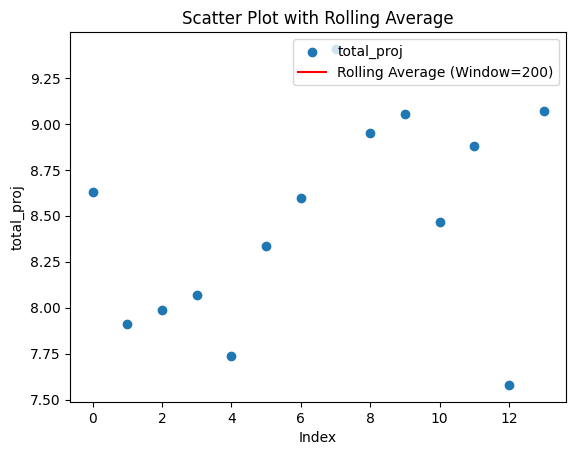

In [121]:
# Total: Choose Vegas or Actual to compare my runs to 
# total = "TotalVegasRuns"
total = "total_act"

gambling_df = gambling_df.sort_values('date', ascending=True).reset_index(drop=True)

# You can convert the index to a list for the x-axis and get the values for the y-axis
x_values = gambling_df.index.tolist()
y_values = gambling_df['total_proj'].tolist()

# Calculate the rolling average
rolling_avg = gambling_df[f'{total}'].rolling(window=200, min_periods=100).mean()

# Create a scatter plot
plt.scatter(x_values, y_values, label='total_proj')

# Add the rolling average line
plt.plot(x_values, rolling_avg, color='red', label='Rolling Average (Window=200)')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('total_proj')
plt.title('Scatter Plot with Rolling Average')
plt.legend()

# Show the plot
plt.show()

In [122]:
gambling_df

,game_id,away_team,home_team,date,game_num,VisitorModelRuns,HomeModelRuns,away_id,home_id,game_num_act,away_score_act,home_score_act,venue_id,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPick,OverUnderPick,MLPick,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,SpreadAct,SpreadSide,TotalModelRuns,SpreadPayoutGroup,OverUnderPayoutGroup,MLPayoutGroup,ModelDiff,VegasDiff,toohigh
0,744861,TOR,WSN,20240505.000000,1.000000,4.322421,4.306548,141.000000,120.000000,1.000000,0.000000,0.000000,3309.000000,1.500000,8.500000,2.600000,1.520833,1.980392,1.847458,1.952381,1.869565,NaN,NaN,8.628968,0.497024,0.502976,0.000000,0.000000,0.000000,1.000000,0.000000,0.353175,0.646825,0.000000,0.000000,1.000000,0.000000,0.478175,0.521825,0.000000,0.000000,0.918254,0.983714,0.984302,0.929227,0.933579,0.975587,0.000000,1.520833,0.000000,1.847458,0.000000,0.000000,Neither,Neither,Neither,NaN,NaN,NaN,NaN,NaN,NaN,4.322421,NaN,18.683320,NaN,4.306548,NaN,18.546352,NaN,NaN,1.520833,Neither,8.628968,NaN,NaN,NaN,0.015873,NaN,1
1,745103,NYM,TBR,20240505.000000,1.000000,4.014881,3.895833,121.000000,139.000000,1.000000,3.000000,3.000000,12.000000,1.500000,7.000000,2.640000,1.505051,1.819672,2.020000,1.909091,1.909091,NaN,NaN,7.910714,0.472222,0.395833,0.131944,6.000000,0.000000,1.000000,0.000000,0.382937,0.617063,0.000000,0.000000,1.000000,0.000000,0.513889,0.486111,0.000000,0.000000,1.010952,0.928712,0.991234,0.931528,0.981061,0.928030,0.000000,1.505051,0.000000,2.020000,0.000000,0.000000,Away,Neither,Neither,0.000000,NaN,NaN,1.010952,NaN,NaN,1.014881,NaN,1.029983,NaN,0.895833,NaN,0.802517,NaN,NaN,1.505051,Favorite,7.910714,1.000000,NaN,NaN,0.119048,NaN,1
2,745185,CHW,STL,20240505.000000,1.000000,3.768849,4.217262,145.000000,138.000000,1.000000,1.000000,0.000000,2889.000000,-1.500000,7.500000,1.617284,2.360000,1.869565,1.952381,2.360000,1.617284,NaN,NaN,7.986111,0.500000,0.500000,0.000000,1.000000,0.000000,1.000000,0.000000,0.623016,0.376984,0.000000,1.000000,0.000000,0.000000,0.437500,0.562500,1.000000,0.000000,1.007594,0.889683,0.934783,0.976190,1.032500,0.909722,1.617284,0.000000,0.000000,1.952381,2.360000,0.000000,Away,Neither,Away,1.617284,NaN,2.360000,1.007594,NaN,1.032500,2.768849,NaN,7.666526,NaN,4.217262,NaN,17.785298,NaN,NaN,1.617284,Underdog,7.986111,1.000000,NaN,1.000000,0.448413,NaN,1
3,745504,COL,PIT,20240505.000000,1.000000,3.935516,4.130952,115.000000,134.000000,1.000000,3.000000,1.000000,31.000000,-1.500000,7.000000,1.617284,2.360000,1.847458,1.980392,2.360000,1.617284,NaN,NaN,8.066468,0.510913,0.367063,0.122024,4.000000,0.000000,1.000000,0.000000,0.637897,0.362103,0.000000,1.000000,0.000000,0.000000,0.451389,0.548611,1.000000,0.000000,1.031660,0.854563,1.065913,0.848953,1.065278,0.887260,1.617284,0.000000,0.000000,1.980392,2.360000,0.000000,Away,Over,Away,1.617284,0.000000,2.360000,1.031660,1.065913,1.065278,0.935516,NaN,0.875190,NaN,3.130952,NaN,9.802863,NaN,NaN,1.617284,Underdog,8.066468,1.000000,1.000000,1.000000,0.195437,NaN,1
4,745667,MIA,OAK,20240505.000000,1.000000,3.858135,3.879960,146.000000,133.000000,1.000000,0.000000,0.000000,10.000000,-1.500000,7.500000,1.571429,2.450000,1.869565,1.952381,2.200000,1.704225,NaN,NaN,7.738095,0.453373,0.546627,0.000000,0.000000,0.000000,1.000000,0.000000,0.648810,0.351190,0.000000,1.000000,0.000000,0.000000,0.469246,0.530754,0.000000,0.000000,1.019558,0.860417,0.847610,1.067224,1.032341,0.904524,1.571429,0.000000,